## Preliminaries

To begin, we load in our knapsack instances

In [1]:
import h5py
import numpy as np
from tqdm.auto import tqdm
import ast  # safely parse string lists
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver

def load_knapsacks(file):
    instances = []
    with h5py.File(file, "r") as f:
        for key in sorted(f.keys(), key=lambda x: int(x)):
            grp = f[key]
            instance = {}
            for k, v in grp.items():
                data = v[()]
                if isinstance(data, bytes):
                    data = data.decode("utf-8")
                if isinstance(data, str) and data.startswith("[") and data.endswith("]"):
                    try:
                        data = np.array(ast.literal_eval(data), dtype=float)
                    except Exception:
                        pass
                if isinstance(data, np.generic):
                    data = data.item()
                instance[k] = data
            instances.append(instance)
    return instances


# Load data
instances = load_knapsacks("knapsacks.h5")
k_values = [0, 5, 10, 50, 100, 500, 1000, 10000]
colours = ['blue', 'green', 'orange', 'red', 'k', 'purple', 'lightblue', 'pink']
instance_index = 0
instance=instances[instance_index]

In [2]:
weights = np.array(instance["weights"])
values = np.array(instance["values"])
capacity = instance["capacity"]
type_ = instance["type"]
k = instance["k"]
n=instance["n"]
print(f'This instance is of type {instance["type"]}')
ratios = values / weights
if instance["type"]=="from_hard_paper":
    OG=0.1
    k=8
else:
    OG=1e-9

print(f'The value of k that we will use to construct the warm-start solution is {k}')

This instance is of type from_hard_paper
The value of k that we will use to construct the warm-start solution is 8


In [3]:
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver

result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                            time_limit=60,
                                            optimality_gap=OG,
                                            feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']
print(f'Optimal weight found by Gurobi {optimal_weight}')
print(f'Optimal value found by Gurobi {optimal_value}')
print(f'Does the capacity exceed the optimal weight solution found from Gurobi? {capacity>=optimal_weight}')

Restricted license - for non-production use only - expires 2026-11-23
Optimal weight found by Gurobi 9688005031.0
Optimal value found by Gurobi 9688004960.0
Does the capacity exceed the optimal weight solution found from Gurobi? True


# Basic Demo and debugging of the xQAOA solver. 

## Problem Setup and Classical Solutions

Let's make a plot of all the items in the knapsack and their values and weights.

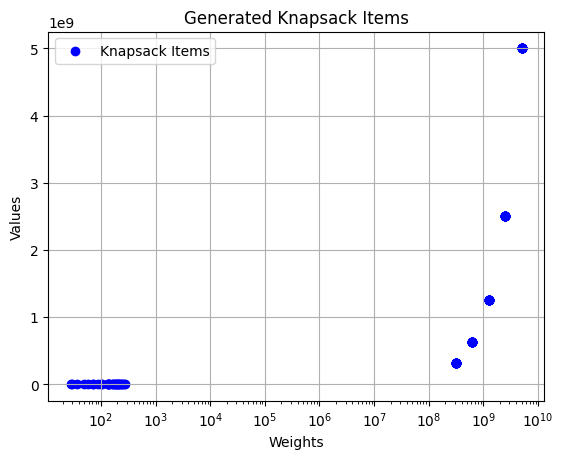

In [4]:
# Plot the knapsack items
import matplotlib.pyplot as plt
plt.scatter(weights, values, color='blue', marker='o', label='Knapsack Items')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.xscale('log')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Let's also visualize the rations of values and weights

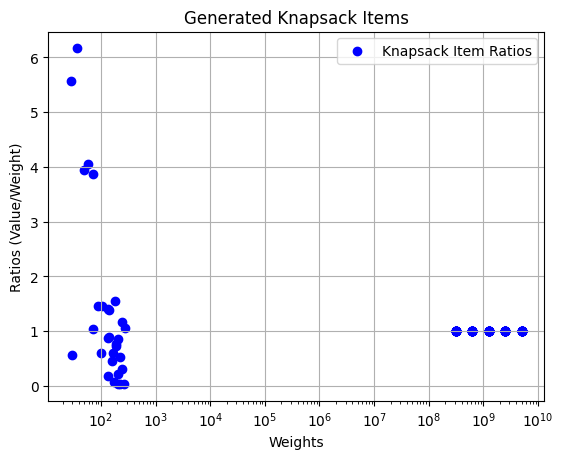

In [5]:
ratios = values / weights
plt.scatter(weights, ratios, color='blue', marker='o', label='Knapsack Item Ratios')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.xscale('log')
plt.ylabel('Ratios (Value/Weight)')
plt.legend()
plt.grid(True)
plt.show()

Now let's do a comparison with Gurobi

Knapsack Capacity: 1.0000e+10
Total Value of optimal solution: 9.6880e+09
Total Weight of optimal solution: 9.6880e+09
Runtime: 0.000904 seconds


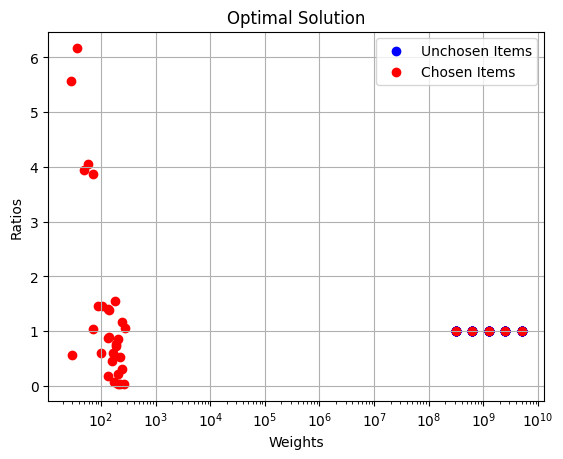

In [6]:
# Solve the knapsack problem using Gurobi
print(f"Knapsack Capacity: {format(capacity,'.4e')}")
print(f"Total Value of optimal solution: {format(result_gurobi['total_value'],'.4e')}")
print(f"Total Weight of optimal solution: {format(result_gurobi['total_weight'],'.4e')}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

As a sanity check, lets construct the greedy solution and see how it compares to Gurobi. 

Greedy Solution Value: 9688907129.0
Greedy Solution Weight: 9688905816.0


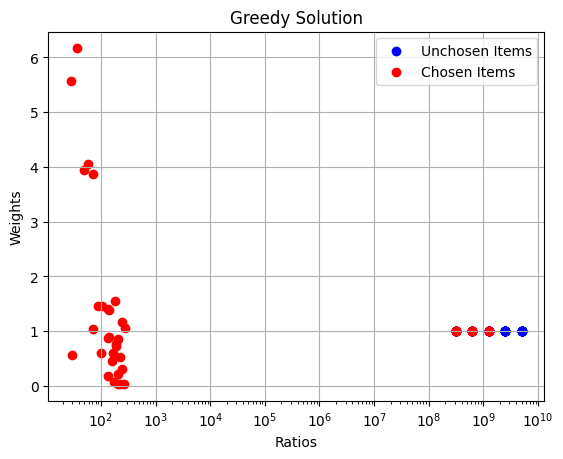

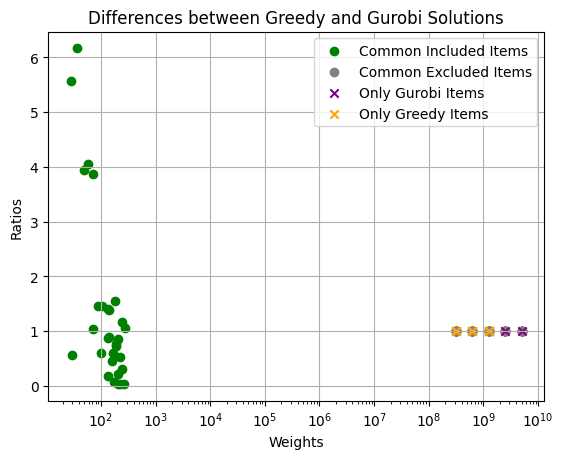

Gurobi solution obtains a value -902169.0000 above the greedy solution.
This corresponds to greedy being a fraction -0.0001 off optimal.


In [7]:
greedy_weight = 0
greedy_solution = np.zeros(n, dtype=bool)

# Order items by their ratio with weight as the tiebreaker
greedy_order = np.lexsort((-weights, -ratios))

for i in greedy_order:
    if greedy_weight + weights[i] <= capacity:
        greedy_solution[i] = True
        greedy_weight += weights[i]
    
greedy_value = np.sum(values[greedy_solution])
print(f"Greedy Solution Value: {greedy_value}")
print(f"Greedy Solution Weight: {greedy_weight}")
# Plot the greedy solution
plt.figure()
plt.scatter(weights[~greedy_solution], ratios[~greedy_solution], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[greedy_solution], ratios[greedy_solution], color='red', marker='o', label='Chosen Items')
plt.title('Greedy Solution')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

# Plot the indices where the greedy solution and Gurobi solution differ
diff_indices = np.logical_xor(greedy_solution, soln_mask)
diff_gurobi_solutions = np.logical_and(soln_mask, diff_indices)
diff_greedy_solutions = np.logical_and(greedy_solution, diff_indices)
common_solutions = np.logical_and(greedy_solution, soln_mask)
common_excluded = np.logical_and(~greedy_solution, ~soln_mask)
plt.figure()
plt.scatter(weights[common_solutions], ratios[common_solutions], color='green', marker='o', label='Common Included Items')
plt.scatter(weights[common_excluded], ratios[common_excluded], color='gray', marker='o', label='Common Excluded Items')
plt.scatter(weights[diff_gurobi_solutions], ratios[diff_gurobi_solutions], color='purple', marker='x', label='Only Gurobi Items')
plt.scatter(weights[diff_greedy_solutions], ratios[diff_greedy_solutions], color='orange', marker='x', label='Only Greedy Items')
plt.title('Differences between Greedy and Gurobi Solutions')
plt.xlabel('Weights')
plt.xscale('log')
plt.ylabel('Ratios')
plt.legend()
plt.grid(True)
plt.show()

print(f"Gurobi solution obtains a value {optimal_value - greedy_value:.4f} above the greedy solution.")
print(f"This corresponds to greedy being a fraction {(optimal_value - greedy_value)/optimal_value:.4f} off optimal.")


## Quantum Solution

### Classical Warm Start Distribution

Our starting point for the Quantum Solution is a classical warm start. 

To understand this distribution we first construct the "lazy greedy" classical solution. This is obtained similarly to the greedy classical solution constructed above, only the algorithm stops when it encounters the first item that doesn't fit into the knapsack.

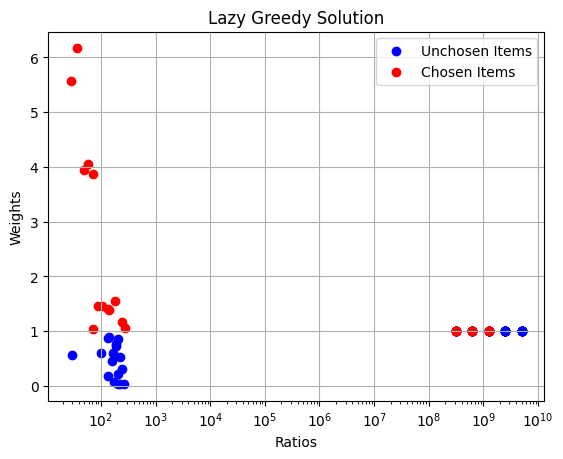

In [8]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    # Constructs a lazy greedy solution
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(n, dtype=bool)

    # Order items by their ratio with weight as the tiebreaker
    greedy_order = np.lexsort((-weights, -ratios))

    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

lgs = construct_lazy_greedy_solution(weights, ratios, capacity)
plt.figure()
plt.scatter(weights[~lgs], ratios[~lgs], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[lgs], ratios[lgs], color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()



This solution will never be better than the greedy solution visualized above, but it does give us a useful starting point for constructing our warm start distribution. 

As a first step, notice that if we sort items by ratio of (value/weight) the lazy greedy distribution has a cutoff above which all items are included in the solution, and below which items are excluded. 

In the next plot we visualize this as giving a `probability' (either 0 or 1) of being included in the lazy greedy solution. This is to prepare us for the warm start distribution, which we define next. 



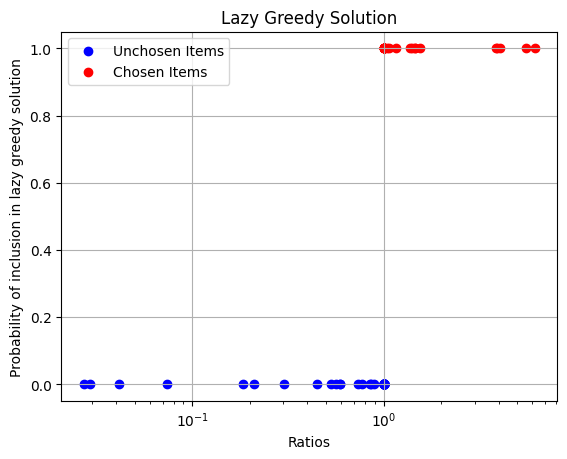

In [9]:
plt.figure()
plt.scatter(ratios[~lgs], np.zeros_like(values[~lgs]), color='blue', marker='o', label='Unchosen Items')
plt.scatter(ratios[lgs], np.ones_like(values[lgs]), color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.xscale('log')
plt.ylabel('Probability of inclusion in lazy greedy solution')
plt.legend()
plt.grid(True)
plt.show()

Our warm start distribution can now be obtained by "smoothing out" the above probabilities slightly. It is defined in terms of an inverse temperature parameter k, which was obtained when these instances were initialized above.

Best valid solution value is: 9688504208.0
Ratio of best valid solution to optimal value is: 1.00005
Worst invalid solution is: 10000201614.0
Optimal solution value is: 9688004960.0
Probability of valid samples: 0.5284
Approximation ratio of valid samples: 0.5946


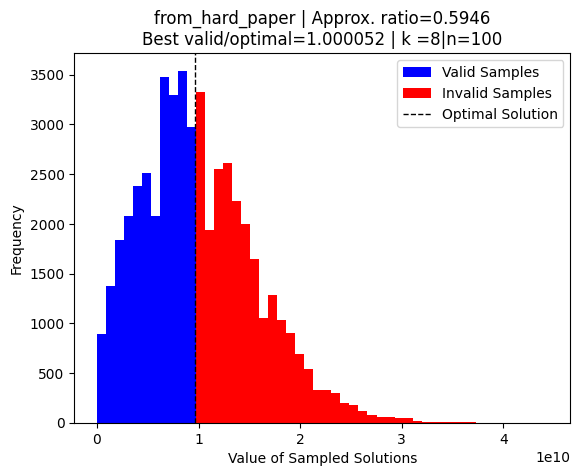

In [10]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(len(weights), dtype=bool)
    greedy_order = np.lexsort((-weights, -ratios))
    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    ratios = values / weights
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, ratios, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution])
    uniform_probability = np.sum(weights) / capacity
    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)

# Now sample from this distribtion
num_samples =  50000
samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
total_values = np.sum(samples * values, axis=1)
total_weights = np.sum(samples * weights, axis=1)
valid_samples = total_weights <= capacity

# Some nice to have statistics
probability_valid = np.sum(valid_samples) / num_samples
approximation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

# Lets make a histogram showing the total value of the samples
plt.figure()
plt.hist([total_values[valid_samples],total_values[~valid_samples]], bins=50, stacked = True, color=['blue','red'], label=['Valid Samples', 'Invalid Samples'])
plt.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal Solution')
plt.title(
    f'{type_} | Approx. ratio={approximation_ratio_of_valid:.4f}\n'
    f'Best valid/optimal={np.max(total_values[valid_samples]) / optimal_value:.6f} | k ={k}|n={n}'
)
plt.xlabel('Value of Sampled Solutions')
plt.ylabel('Frequency')
plt.legend()

print(f"Best valid solution value is: {np.max(total_values[valid_samples])}")
print(f"Ratio of best valid solution to optimal value is: {np.max(total_values[valid_samples])/optimal_value:.5f}")
print(f"Worst invalid solution is: {np.min(total_values[~valid_samples])}")
print(f"Optimal solution value is: {optimal_value}")
print(f"Probability of valid samples: {probability_valid}")
print(f"Approximation ratio of valid samples: {approximation_ratio_of_valid:.4f}")

The fundamental question we investigate next is whether we can improve performance of our solution by postprocessing the distribution with a quantum circuit. 

### Preparing Warm Start Distribution on a Quantum Computer 

In our quantum circuit, each qubit will represent one item in the knapsack. At the end of the circuit we measure all the qubits to produce a solution to the knapsack problem -- if a qubit is measured in the $\ket{1}$ state then the corresponding item will be in the napsack solution, and if is measured in the $\ket{0}$ state the corresponding item will be excluded from the soltuion. 

The first step then, is to initialize a quantum circuit with as many qubits as we have potential items to put in the knapsack. Then we prepare those qubits in a state whose measurement statistics match the warm start distribution described above on a quantum computer. We do this by rotating each qubit about the Y-axis to produce the state $\sqrt{1-p_i}\ket{0} + \sqrt{p_i}\ket{1}$ where $p_i$ is the probability the warm start distribution assignes to the $i$-th item. 

An important detail when we move on to constructing the xQAOA mixer will be the physical layout of our qubits. We order our qubits in terms of increasing ratio, so that adjacent qubits correspond to items with similar ratios of value/weight. When items have an identical ratio we use weight as a tiebreaker.

In [11]:
from qiskit import QuantumCircuit
warm_start_distribution = smoothed_distribution
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = warm_start_distribution[qubit_order]
ordered_weights = weights[qubit_order]
ordered_values = values[qubit_order]
ordered_ratios = ratios[qubit_order]

qc = QuantumCircuit(n)

def initialize_warm_start_distribution(quantum_circuit, distribution):
    """
    Initializes the quantum circuit with the given distribution.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to initialize.
        distribution (np.ndarray): The distribution to use for initialization.
    """
    for i in range(len(distribution)):
        angle = 2 * np.arcsin(np.sqrt(distribution[i]))
        quantum_circuit.ry(angle, i)  # Rotate qubit i by appropriate angle.
    
    qc.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)


Let's re-obtain the Gurobi solution for this new ordering

Knapsack Capacity: 1.0000e+10
Total Value of optimal solution: 9.6889e+09
Total Weight of optimal solution: 9.6889e+09
Runtime: 0.000591 seconds


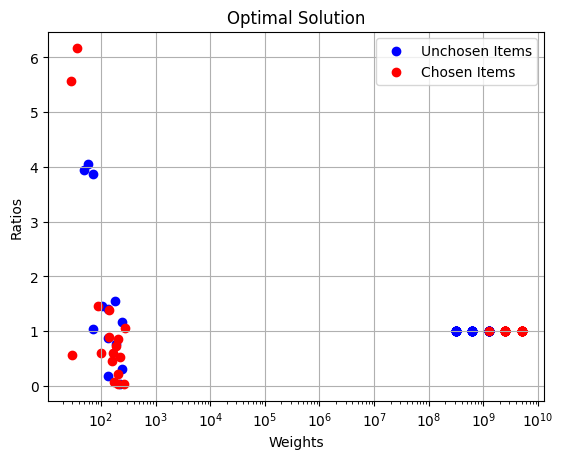

In [12]:
result_gurobi = gurobi_knapsack_solver(ordered_values, ordered_weights, capacity, verbose=False,
                                        optimality_gap=1e-1,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

print(f"Knapsack Capacity: {format(capacity, '.4e')}")
print(f"Total Value of optimal solution: {format(result_gurobi['total_value'], '.4e')}")
print(f"Total Weight of optimal solution: {format(result_gurobi['total_weight'], '.4e')}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

## The Copula Mixer

Now that we have initialized the warm start distribution on a quantum computer, we can use standard optimization techniques to try and shift the state towards an optimal (or near-optimal) knapsack solution. But if we try to apply standard QAOA techinques we encounter a problem. The knapsack problem is a constrained optimization problem, while QAOA is most naturally suited to *unconstrained* otpmization. It is always possible to add constraints, in the form of a penalty term, to the QAOA cost function then proceed like normal. But this approach complicates the cost function, and may (for inequality constraints as in the knapsack problem) also requires introducing slack variables which drive up the qubit count.  

An alternate approach to constrained optimization is to modify the QAOA mixer, so that the mixer dynamics naturally respect the constraints of the problem. But pursuing this approach in the case of the knapsack problem requires performing coherent addition between the qubits, which is out of scope for current quantum hardware. 

Here we pursure an alternate approach -- proposed in https://arxiv.org/abs/2108.08805 -- in which we modify the mixer in a way that we hope will approximately respect the knapsack constraints. This is less costly then the approach described in the previous paragraph, but still gives a way of partially incorporating constraints into the QAOA framework. 

The basic building block of this appraoch is a two-qubit mixer which we call the Copula mixer. This mixer takes as input variabels $\theta, p_1,$ and $p_2$, in addition to a parameter $\beta$ which controls the mixer strength as in standard QAOA. To explain this mixer, we first define the *Copula Distribution* $p_{cop}$ to be a distribution over two bits with: 

$$
\begin{align}
p_{cop}(0,0) &= (1 - p_1)(1-p_2) + \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(0,1) &= (1 - p_1)(p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,0) &= (p_1)(1-p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,1) &= (p_1)(p_2) + \theta p_1 p_2(1 - p_1)(1-p_2)
\end{align}
$$

Straightforward computation shows that this distribution has single-bit marginal probabilities matching the proabilities $p_1$ and $p_2$ used in its definition. The $\theta$ parameter takes values in $[-1,1]$ and controls whether the two bits are correlated or anti-correlated in this distribution. When $\theta = -1$ bits are maximally anti-correlated, and $\theta = 1$ corresponds to bits being maximally correlated.  

Now we construct a unitary $R_{cop}$ satisfying $R_{cop}\ket{00} = \ket{p_{cop}}$ and define the mixer Hamiltoniaon $H_{cop} = -R_{cop}^\dagger (ZZ) R_{cop}$. Then the state $\ket{p_{cop}} = \sum_{x_1, x_2} \sqrt{p_{cop}(x_1,x_2)} \ket{x_1, x_2}$ is the ground state of the Hamiltonian with eigenvalue $-2$, and all other eigenstates have eigenvalue $\geq 0$. Finally, the Copula mixer in terms of $\beta$ is defined by 

$$
\begin{align}
U_{cop, \beta} = \exp(-i \beta H_{cop}).
\end{align}
$$

Note that setting $\beta = 0$ turns off the Copula mixer. Since the eigenvalues of $H_{cop}$ are multiples of two, **the mixer is period in $\beta$ with a periodicity of $\pi$**, i.e. we have $U_{cop, \ \beta} = U_{cop,\ \beta + \pi}$ for any $\beta$. 

In [13]:
def construct_cop(p_1, p_2, beta, theta = -1):
    """
    Constructs a two qubit copula mixer with the given parameters.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum on which we add the Copula mixer.
        p_1 (float): Probability p_1 in the definition of the copula mixer.
        p_2 (float): Probability p_2 in the definition of the copula mixer.
        beta (float): The strength of the copula mixer.
        theta (float): The theta parameter of the copula mixer, which controls whether qubits are correlated or anti-correlated. Should take values in [-1,1] and defaults to -1, which means maximum anticorrelation.

    Returns:
        QuantumCircuit: The quantum circuit with the copula mixer added.
    """

    # We first construct a rotation operator designed to rotate the |00> state to the |p_cop> state.
    rotation_circuit = QuantumCircuit(2)
    phi_1 = 2 * np.arcsin(np.sqrt(p_1))  
    p_2_given_1 = (p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2))/ p_1
    phi_2_given_1 = 2 * np.arcsin(np.sqrt(p_2_given_1))
    p_2_given_not1 = ((1- p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)) / (1 - p_1)
    phi_2_given_not1 = 2 * np.arcsin(np.sqrt(p_2_given_not1))

    rotation_circuit.ry(phi_1, 0)  # Rotate first qubit to the correct marginal distribution
    rotation_circuit.cry(phi_2_given_1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |1>
    rotation_circuit.x(0)  # Flip qubit 1
    rotation_circuit.cry(phi_2_given_not1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |0>
    rotation_circuit.x(0)  # Undo flip

    copula_mixer = QuantumCircuit(2)
    copula_mixer.compose(rotation_circuit.inverse(), inplace=True) # rotate |p_cop> to |00>
    copula_mixer.barrier()  
    # In this rotated basis, the copula mixer is diagonal, so we can impliment with RZ gates.
    copula_mixer.rz(-2* beta, 0)  
    copula_mixer.rz(-2 *beta, 1)  
    copula_mixer.barrier()  
    copula_mixer.compose(rotation_circuit, inplace=True) # rotate |00> back to |p_cop>

    return copula_mixer
    

Now lets run some basic tests to verify the copula is working as intended. 

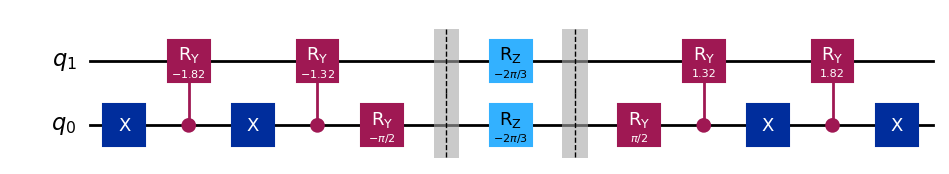

Eigenvalues of the copula mixer: 

Eigenvalue: 1.0000+0.0000j
Eigenvector: -0.7071-0.0000j |00>  + 0.0000+0.0000j |01> + -0.0000-0.0000j |10> + 0.7071+0.0000j |11>
Eigenvalue: -0.5000-0.8660j
Eigenvector: 0.5590+0.0000j |00>  + -0.4330+0.0000j |01> + -0.4330-0.0000j |10> + 0.5590+0.0000j |11>
Eigenvalue: -0.5000+0.8660j
Eigenvector: 0.4330+0.0000j |00>  + 0.5590+0.0000j |01> + 0.5590+0.0000j |10> + 0.4330-0.0000j |11>
Eigenvalue: 1.0000-0.0000j
Eigenvector: 0.2963+0.1538j |00>  + 0.6233+0.0000j |01> + -0.6233-0.0000j |10> + -0.2963-0.1538j |11>

We expect an eigenvector: 0.4330 |00> + 0.5590 |01> + 0.5590 |10> + 0.4330 |11>
with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = -0.5000+0.8660j


In [14]:
from qiskit.quantum_info import Operator 

# Test the copula mixer construction.
test_copula_mixer = construct_cop(0.5, 0.5, np.pi/3)

display(test_copula_mixer.draw('mpl', scale=1, idle_wires=False, fold=-1, reverse_bits=True))

# This unitary is small enough we can just check its eigenvectors and eigenvalues directly. 
cop_unitary = Operator(test_copula_mixer).data
eigenvalues, eigenvectors = np.linalg.eig(cop_unitary)

print("Eigenvalues of the copula mixer: \n")
for i, ev in enumerate(eigenvalues):
    print(f"Eigenvalue: {ev:.4f}")
    print(f"Eigenvector: {eigenvectors[0,i]:.4f} |00>  + {eigenvectors[1,i]:.4f} |01> + {eigenvectors[2,i]:.4f} |10> + {eigenvectors[3,i]:.4f} |11>")  


p_1 = 0.5
p_2 = 0.5
theta = -1
p_cop_00 = (1 - p_1) * (1 - p_2) + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_01 = (1 - p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_10 = p_1 * (1 - p_2) - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_11 = p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)

print(f"\nWe expect an eigenvector: {np.sqrt(p_cop_00):.4f} |00> + {np.sqrt(p_cop_01):.4f} |01> + {np.sqrt(p_cop_10):.4f} |10> + {np.sqrt(p_cop_11):.4f} |11>")
print(f"with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = {np.exp(2j * np.pi / 3):.4f}")


Now we can construct the "ring" copula mixer proposed in https://arxiv.org/pdf/2108.08805. The idea is to visualize the qubits as lying in a ring, and to apply the two qubit copula mixer defined above between nearest neighbour terms on the ring. We get the probabilities $p_i$ and $p_j$ used in the defintion of each copula mixer from the warm start distribution we used to initialize our quantum state. 

This should have the effect of leaving the qubits with high ratios of value-to-weight as very likely in the knapsack, and the low ratio qubits as very likely excluded from the knapsack, but it will encourage mixing between the qubits with middling value. This mixing should anti-correlate nearby terms -- adding an item to the knapsack while removing an item with similar ratio -- and thus approximately preserve the overall knapsack weight.

In [15]:
def add_ring_copula(quantum_circuit, probability_dist, beta):
    """
    Constructs a ring copula mixer on the given quantum circuit.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the ring copula mixer.
        probability_dist (np.ndarray): The probability distribution to use for the copula mixer.
    """
    n = len(probability_dist)
    for i in range(1,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    for i in range(2,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    quantum_circuit.barrier()  
    return quantum_circuit

To complete the setup for xQAOA we also need to define a cost function. Because we have encoded a (soft) version of our constraints into our mixer we leave constraints out of this cost function. But then it is particularly straightfoward -- we simply sum the values of each of the items included in the knapsack. 

As in standard QAOA we also multiple our cost function by a $\gamma$ parameter. Because we want this parameter to take values in $[0,2\pi]$, we will normalize all our values by the max possible value so the normalized values lie in $[0,1]$. 

In [16]:
def add_knapsack_cost_function(quantum_circuit, values, gamma):
    """
    Adds a cost function to the quantum circuit that sums the values of the items included in the knapsack.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the cost function.
        values (np.ndarray): The values of the items in the knapsack.
        gamma (float): The strength of the cost function.
    """

    max_value = np.max(values)
    n = len(values) 
    for i in range(n):
        quantum_circuit.p(gamma * values[i]/max_value, i)  # Apply RZ gate with angle proportional to value
    quantum_circuit.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

### Train for beta and gamma and compare warm start, random distribution, and xQAOA

#### Simulation setup

In [17]:
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit import Parameter
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import QiskitRuntimeService

service=QiskitRuntimeService(name='pinq')
backend = service.backend('ibm_quebec')
optimization_level=3
pm = generate_preset_pass_manager(backend=backend, optimization_level = optimization_level, seed_transpiler=111)
nm = None
coupling_map = backend.configuration().coupling_map
basis_gates = backend.basis_gates

# initialize simulator
sampler_mps = SamplerV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                                 })

Let's try a sampler based optimization. This is quicker than the estimator based optimization

In [18]:
# Sampler based optimization
from scripts.utils.kp_utils import get_weight, get_value
from qiskit import transpile



def sampler_based_optimizer(qc, capacity, shots=10_000):
    qc = transpile(qc, basis_gates = backend.basis_gates)
    qc.measure_active()
    job = sampler_mps.run([(qc,)], shots=shots)
    sampler_result = job.result()
    sampled_counts = sampler_result[0].data.meas.get_counts() 
    shots = sum(sampled_counts.values())
    filtered_bitstrings= []
    filtered_cost_values = []
    for key in sampled_counts.keys():
        if get_weight(key[::-1], ordered_weights) <= capacity:
            filtered_bitstrings.append(key)
            filtered_cost_values.append(get_value(key[::-1], ordered_values) * sampled_counts[key]/shots)
        else: 
            continue
    filtered_distribution = {
        key: val / shots for key, val in sampled_counts.items() if key in filtered_bitstrings
    }
    filtered_exp_val = sum(filtered_cost_values)

    return filtered_distribution, filtered_exp_val

In [ ]:
from scipy.optimize import minimize
from qiskit.circuit.parameter import Parameter

layers=5
max_iter=4
params=[]
results={}
shots=10_000
p_values=[1, 2, 3, 4, 5]

gammas = [Parameter(f"gamma_{i}") for i in p_values]
betas = [Parameter(f"beta_{i}") for i in p_values]

def cost_to_minimize(params:list, qc:QuantumCircuit):
    circ = qc.copy()
    circ.assign_parameters(params, inplace=True)
    _,cost = sampler_based_optimizer(circ, capacity=capacity, shots=shots)
    return -cost



# def interpolate_initialize(
#     opt_gamma: np.ndarray, opt_beta: np.ndarray, p_new: int
# ) -> Tuple[np.ndarray]:
#     """
#     Interpolates QAOA parameters to a higher depth with scaling.

    

#     Parameters:
#         opt_gamma (np.ndarray): Optimized gamma parameters from depth p.
#         opt_beta (np.ndarray): Optimized beta parameters from depth p.
#         p_new (int): New depth for interpolation.

#     Returns:
#         new_gamma (np.ndarray): Interpolated gamma parameters for depth p_new.
#         new_beta (np.ndarray): Interpolated beta parameters for depth p_new.
#     """
#     p_old = len(opt_gamma)

#     # Create evenly spaced points for old and new depths
#     x_old = np.linspace(0, 1, p_old)
#     x_new = np.linspace(0, 1, p_new)

#     # Interpolate gamma and beta with scaling
#     new_gamma = np.interp(x_new, x_old, opt_gamma)
#     new_beta = np.interp(x_new, x_old, opt_beta)

#     return new_gamma, new_beta

# p_values=[1, 2, 3, 4, 5]
# p_final = p_values[-1]
# results = {}
# qc = QuantumCircuit(n)
# qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
# opt_beta, opt_gamma = ([2.75412807], [0.30202833]) # intitial values calculated earlier.
# for i,p in enumerate(p_values):
        # results[p] = {}
        # init_params = np.concatenate((opt_beta, opt_gamma))
        # qc = add_knapsack_cost_function(qc, ordered_values, gamma=gammas[i])
        # qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[i])
        # Result = minimize(
        #     cost_to_minimize,
        #     init_params,
        #     args=qc,
        #     method="COBYLA",
        #     bounds=[(0, np.pi), (0, 2*np.pi)]*p,
        #     tol=1e-2,
        #     options={"maxiter": 50000},
        #     )

        # # Store optimized parameters
        # results[p] = {
        #     "beta": Result.x[:p],
        #     "gamma": Result.x[p:],
        #     "func": Result.fun,
        #     "nfev": Result.nfev,
        # }

        # if p < p_final:
        #     opt_gamma, opt_beta = interpolate_initialize(
        #         results[p]["gamma"], results[p]["beta"], p_values[i + 1]
        #     )

#Old optimization method below
def __optimization_loop__(qc, max_iter=max_iter):
    x_vals= []
    y_vals = []
    for i in range(max_iter):
        for k in range(max_iter):
            init_params = [i*np.pi/(max_iter-1), 2*k*np.pi/(max_iter)]
            result_lc = minimize(
            cost_to_minimize,
            init_params,
            args=qc,
            method="COBYLA",
            bounds=[(0, np.pi), (0, 2*np.pi)],
            tol=1e-2,
            )
            print(result_lc)
            y_vals.append(cost_to_minimize(list(result_lc.x),qc))
            x_vals.append((result_lc.x))
    
    min_params=x_vals[np.argmin(y_vals)]
    return min_params

qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
circuits_at_different_p=[]
with tqdm(total=layers) as pbar:
    for p in range(layers):
            qc = add_knapsack_cost_function(qc, ordered_values, gamma=gammas[p])
            qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[p])
            min_params = __optimization_loop__(qc)
            params.append((min_params))
            qc.assign_parameters(min_params,inplace=True)
            circuits_at_different_p.append(qc.copy())
            pbar.update(1)
    



  0%|          | 0/5 [00:00<?, ?it/s]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3009676857.080599
       x: [ 4.473e-20  9.900e-01]
    nfev: 17
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3076837776.0692983
       x: [-2.009e-19  1.675e+00]
    nfev: 19
   maxcv: 2.0091092001661994e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3328133199.6518
       x: [ 5.590e-02  5.114e+00]
    nfev: 19
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3043585302.178093
       x: [-2.449e-19  6.283e+00]
    nfev: 10
   maxcv: 2.449409077740988e-19
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3833726569.0001945
       x: [ 2.870e+00  3.603e-01]
    nfev: 24
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3503264719.208396
       x: [ 1.493e+00  1.526e+00]


In [20]:
pars=[[2.87023534 ,0.36031419],[0.09533912, 4.56730094],[0.05196536, 6.00121636],[0.06959518, 1.83306134],[0.00979532 ,0.05878343]]

In [21]:
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
circuits_at_different_p=[]
for p in range(layers):
        qc = add_knapsack_cost_function(qc, ordered_values, gamma=gammas[p])
        qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[p])
        min_params = pars.pop(0)
        qc.assign_parameters(min_params,inplace=True)
        circuits_at_different_p.append(qc.copy())

In [199]:
for i in range(len(params)):
    print(f'Optimized parameters for p={i+1}: {params[i]}')

Optimized parameters for p=1: [2.87023534 0.36031419]
Optimized parameters for p=2: [0.09533912 4.56730094]
Optimized parameters for p=3: [0.05196536 6.00121636]
Optimized parameters for p=4: [0.06959518 1.83306134]
Optimized parameters for p=5: [0.00979532 0.05878343]


 Recalculating the distribution from xQAOA using the sampler based optimizer defined above

In [22]:
def convert_bitstring_to_values(counts, v, w, c):
    dict_bit_values_valid = {}
    dict_bit_values_invalid = {}

    for bitstring, count in tqdm(counts.items(), desc="Processing bitstrings", total=len(counts)):
        value = get_value(bitstring, v)
        if get_weight(bitstring, w) <= c:
            dict_bit_values_valid[value] = dict_bit_values_valid.get(value, 0) + count
        else:
            dict_bit_values_invalid[value] = dict_bit_values_invalid.get(value, 0) + count

    if not dict_bit_values_valid:
        print("No valid solutions found!")

    return dict_bit_values_valid, dict_bit_values_invalid

In [23]:
from itertools import islice
import json
from scripts.utils.kp_utils import compute_approximate_ratio, probabilty_success

dict_bit_values_at_different_p  = {}
pubs = []
shots = 100000

for circ in circuits_at_different_p:
    circ.measure_active()
    xp_circ = pm.run(circ)
    pubs.append(xp_circ)

job = sampler_mps.run(pubs, shots=shots)  

In [25]:
for i in range(len(p_values)):
    counts_bin_qc = job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]

    valid_dict_bit_values_qaoa, invalid_dict_bit_values_qaoa = convert_bitstring_to_values(counts_bin_qc_rev, ordered_values, ordered_weights, capacity)

    #Sort the dictionary by value
    sorted_dict_valid_qaoa= dict(sorted(valid_dict_bit_values_qaoa.items(), key=lambda item: item[0], reverse=True))
    dict_bit_values_at_different_p[f"p = {i}"] = sorted_dict_valid_qaoa
    best_value = max(sorted_dict_valid_qaoa.keys())
    best_count = sorted_dict_valid_qaoa[best_value]
    print(f"Best value: {best_value}")

    # store counts dictionaries
    instance_identifier= f'Instance:{instance_index}'
    counts_file = f'./Counts/Simulations/'+f'{instance_identifier},' + f'p:{p_values[i]}'
    file_location = counts_file

    with open(file_location, "w") as f:
        json.dump(counts_bin_qc_rev, f, indent=4)


    valid_shots_qaoa = sum(sorted_dict_valid_qaoa.values())
    approx_ratio_qaoa, _ = compute_approximate_ratio(dict(islice(sorted_dict_valid_qaoa.items(),valid_shots_qaoa)), optimal_value)

    print(f'Approximate ratio at p = {p_values[i]}: {approx_ratio_qaoa}', '\n' 
    f'Number of valid shots at p = {p_values[i]}: {valid_shots_qaoa}')

Processing bitstrings:   0%|          | 0/96042 [00:00<?, ?it/s]

Best value: 9688604089.0
Approximate ratio at p = 1: 0.5102802132474851 
Number of valid shots at p = 1: 77701


Processing bitstrings:   0%|          | 0/99414 [00:00<?, ?it/s]

Best value: 9688704312.0
Approximate ratio at p = 2: 0.6077565997449106 
Number of valid shots at p = 2: 74822


Processing bitstrings:   0%|          | 0/99746 [00:00<?, ?it/s]

Best value: 9688804401.0
Approximate ratio at p = 3: 0.6007674872575941 
Number of valid shots at p = 3: 80510


Processing bitstrings:   0%|          | 0/99947 [00:00<?, ?it/s]

Best value: 9689104715.0
Approximate ratio at p = 4: 0.6289864677131541 
Number of valid shots at p = 4: 82771


Processing bitstrings:   0%|          | 0/99964 [00:00<?, ?it/s]

Best value: 9689005008.0
Approximate ratio at p = 5: 0.6346154630001595 
Number of valid shots at p = 5: 81844


Now let's compare the full QAOA with Warm start

In [26]:
from typing import defaultdict
warm_start_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(int(np.random.random() < pi)) for pi in qubit_ordered_distribution)
    warm_start_counts[bitstring] += 1

valid_dict_bit_values_ws,_ = convert_bitstring_to_values(warm_start_counts, ordered_values, ordered_weights, capacity)

# Compute the probability of sucess
p_sucess_ws= probabilty_success(valid_dict_bit_values_ws, optimal_value)
sorted_dict_ws = dict(sorted(valid_dict_bit_values_ws.items(), key=lambda item: item[0], reverse=True))
valid_shots_ws = sum(sorted_dict_ws.values())
approx_ratio_ws, _ = compute_approximate_ratio(dict(islice(sorted_dict_ws.items(), valid_shots_ws)), optimal_value)
best_value_ws = max(valid_dict_bit_values_ws.keys())
print(f"Best WS value: {best_value_ws}")
print(f"Approximate ratio for warm start {approx_ratio_ws}", '\n'
       f"Number of valid shots for warm start: {valid_shots_ws}")

Processing bitstrings:   0%|          | 0/98489 [00:00<?, ?it/s]

Best WS value: 9688603314.0
Approximate ratio for warm start 0.5913027204048171 
Number of valid shots for warm start: 53147


Let's also add a random distribution as a point of comparison with full QAOA

In [27]:
random_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(x) for x in np.random.randint(2, size=n))
    random_counts[bitstring] += 1


valid_dict_bit_values_random, _ = convert_bitstring_to_values(random_counts, ordered_values, ordered_weights, capacity)
sorted_dict_random = dict(sorted(valid_dict_bit_values_random.items(), key=lambda item: item[0], reverse=True))
valid_shots_random = sum(sorted_dict_random.values())
if valid_shots_random>0:
    approx_ratio_rand, _ = compute_approximate_ratio(dict(islice(sorted_dict_random.items(), valid_shots_random)), optimal_value)


    print(f"Best rand value: {max(valid_dict_bit_values_random.keys())}")
    print(f"Rand approx ratio {approx_ratio_rand}",'\n'
       f"Number of valid shots {valid_shots_random}")

Processing bitstrings:   0%|          | 0/100000 [00:00<?, ?it/s]

No valid solutions found!


Let's make a comparison plot of the various distributions

In [ ]:
def plot_multiple_distributions(data_dict, min_cost=None, 
                           bins_width=50, log=True, output_file=None,
                           colors=None, labels=None, title=None, nb_bins=200,
                           annotations=None, figsize=(10, 6), hist_type='step',
                           hardware=True):
    """
    Plots histograms of multiple distributions on the same plot with optional vertical line.
    
    Parameters:
    data_dict (dict): Dictionary where keys are method names and values are dictionaries 
                     with keys as data points and values as weights.
    min_cost (float, optional): The value at which to draw the vertical line.
    bins_width (int): Number of bins for the histograms.
    log (bool): Whether to use log scale for y-axis.
    output_file (str, optional): File path to save the plot (e.g., "output.png").
    colors (dict, optional): Dictionary mapping method names to colors.
    labels (dict, optional): Dictionary mapping method names to display labels.
    title (str, optional): Title for the plot.
    annotations (dict, optional): Dictionary with annotation text and position.
    figsize (tuple): Figure size (width, height).
    hardware (bool): If the figure corresponds to hardware results or not
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Default colors if not provided
    default_colors = ['steelblue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive']
    
    if colors is None:
        colors = {method: default_colors[i % len(default_colors)] 
                 for i, method in enumerate(data_dict.keys())}
    
    if labels is None:
        labels = {method: method for method in data_dict.keys()}
    
    fig, ax = plt.subplots(figsize=figsize)
    max_height=0
    # Find the global range for consistent binning
    all_values = []
    for method, data in data_dict.items():
        if data:  # Check if data exists
            all_values.extend(list(data.keys()))
    
    if not all_values:
        print("No data to plot")
        return
    
    # Create consistent bins across all distributions
    min_val = min(all_values)
    max_val = max(all_values)
    bins= np.linspace(min_val, max_val, bins_width + 1)
    
    # Plot each distribution
    for i, (method, data) in enumerate(data_dict.items()):
        if not data:  # Skip if no data
            continue
            
        values = list(data.keys())
        weights = list(data.values())
        counts, bins, patches = ax.hist(
            values,
            weights=weights,
            bins=nb_bins,
            edgecolor=colors[method],
            alpha=0.6,
            stacked=True,
            color=colors[method],
            label=labels[method],
            histtype=hist_type,
            linewidth=1,
        )
        
        current_max = max(counts) if len(counts) > 0 else 0
        max_height = max(max_height, current_max)
      
    # Add vertical line for optimal value if provided
    if min_cost is not None:
        ax.axvline(min_cost, linestyle="--", color="black", label="Gurobi", linewidth=1.5)
    
    # Add annotations if provided
    if annotations:
        text = "\n".join([f"{k}: {v:}" for k, v in annotations.items()])
        fig.text(
            0, -0.1, text,
            transform=ax.transAxes,
            fontsize=10,
            ha="left",
            va="bottom",
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.4)
        )
    
    # Set log scale for y-axis if requested
    if log:
        ax.set_yscale("log")
        ax.set_xscale("log")
    
    # Add labels, title, and legend
    ax.set_ylabel("Counts", fontsize=12)
    ax.set_xlabel("Values", fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(fontsize=10, loc='best');
        
    plt.tight_layout()

    plot_identifier= f'Instance:{instance_index}'
    if not hardware:
        output_file = './Plots/Simulations/' + plot_identifier
    else:
        output_file = './Plots/Hardware/' + plot_identifier
    plt.savefig(output_file, bbox_inches="tight", dpi=300);

    plt.show()
    
    return fig, ax

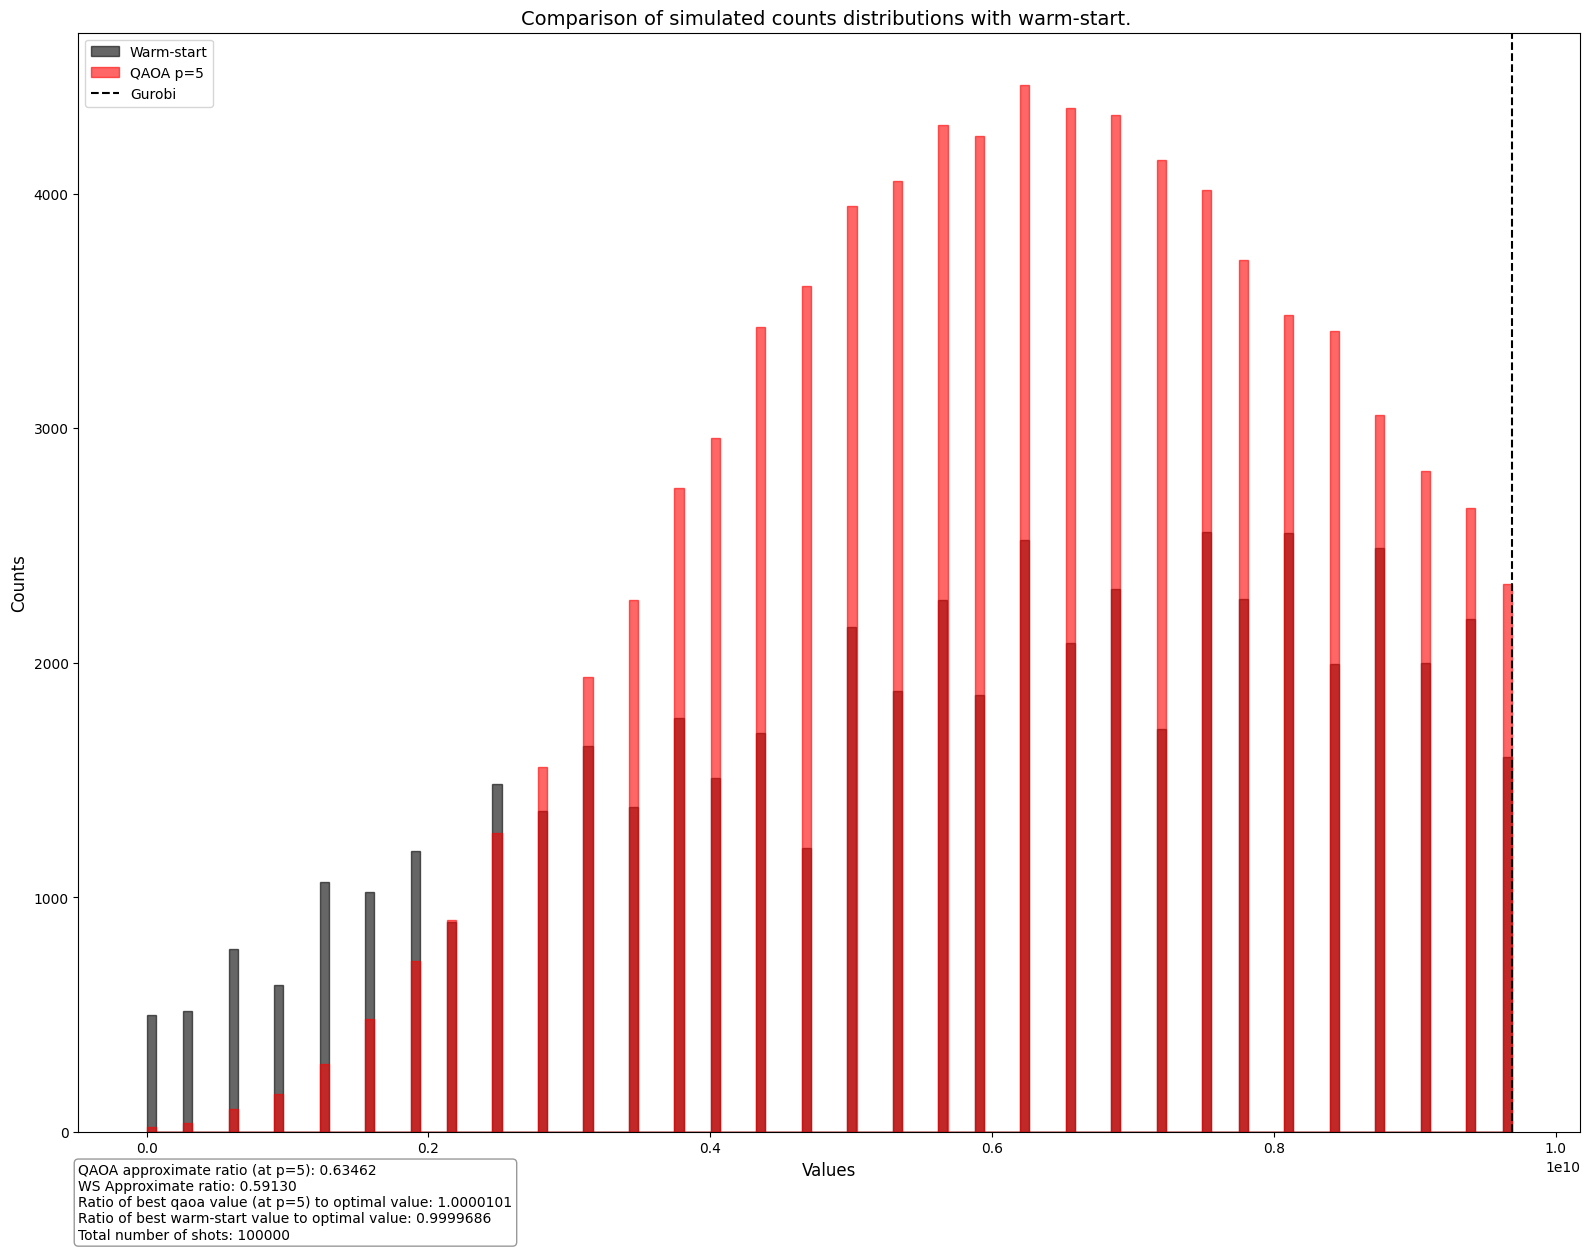

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Comparison of simulated counts distributions with warm-start. '}, xlabel='Values', ylabel='Counts'>)

In [ ]:
data_dict = {
   # f"Random: Apr={norm_approx_ratio_rand:.2f}": dict_bit_values_random,
   f"Warm-start": valid_dict_bit_values_ws,
#    f"QAOA p={1}": dict_bit_values_at_different_p["p = 0"],
#    f"QAOA p={2}": dict_bit_values_at_different_p["p = 1"],
#    f"QAOA p={3}": dict_bit_values_at_different_p["p = 2"],
#    f"QAOA p={4}": dict_bit_values_at_different_p["p = 3"],
   f"QAOA p={5}": dict_bit_values_at_different_p["p = 4"]
}
# Custom colors
colors = {
 #  f"Random: Apr={norm_approx_ratio_rand:.2f}": "yellow",
   f"Warm-start": 'black',
#    f"QAOA p={1}": 'orange',
#    f"QAOA p={2}": 'green',
#    f"QAOA p={3}": "blue",
#    f"QAOA p={4}": "brown",
   f"QAOA p={5}": "red"
}    
# Annotations
annotations = {
    f"QAOA approximate ratio (at p={layers})": f"{approx_ratio_qaoa:.5f}",
    f"WS Approximate ratio" : f"{approx_ratio_ws:.5f}",
    f"Ratio of best qaoa value (at p={layers}) to optimal value" : f"{(best_value/optimal_value):.7f}",
    f"Ratio of best warm-start value to optimal value" : f"{(best_value_ws/optimal_value):.7f}",
    f"Total number of shots" : f"{shots:.0f}",
    }
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=150,
    log=False,
    annotations=annotations,
    figsize=(16,12),
    hist_type='stepfilled',
    title=f"Comparison of simulated QAOA counts distributions with warm-start. ",
    hardware=False
)



### Submit hardware jobs

In [94]:
from qiskit_ibm_runtime import Batch, SamplerV2

SHOTS = 100000


with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = 'XY4'
    sampler.options.twirling.enable_gates = True
    sampler.options.twirling.enable_measure = True
    sampler.options.default_shots = SHOTS
    sampler.options.twirling.strategy="active-circuit"


    job = sampler.run(pubs=pubs) 
    print(f'job_id:{job.job_id()}')

job_id:d4faih12bisc73a2aq00


### Analyze hardware jobs

In [96]:
hardware_dict_bit_values_at_different_p  = {}

for i in range(len(p_values)):
    counts_bin_qc = job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]

    valid_dict_bit_values_qaoa, invalid_dict_bit_values_qaoa = convert_bitstring_to_values(counts_bin_qc_rev, ordered_values, ordered_weights, capacity)

    #Sort the dictionary by value
    sorted_dict_valid_qaoa= dict(sorted(valid_dict_bit_values_qaoa.items(), key=lambda item: item[0], reverse=True))
    hardware_dict_bit_values_at_different_p[f"p = {i}"] = sorted_dict_valid_qaoa
    best_value = max(sorted_dict_valid_qaoa.keys())
    best_count = sorted_dict_valid_qaoa[best_value]
    print(f"Best value: {best_value}")

    # store counts dictionary
    instance_identifier= f'Instance:{instance_index}'
    counts_file = './Counts/Hardware/' + instance_identifier   + f'p:{p_values[i]}'
    with open(counts_file, "w") as f:
        json.dump(counts_bin_qc_rev, f, indent=4)


    valid_shots_qaoa = sum(sorted_dict_valid_qaoa.values())
    approx_ratio_qaoa, _ = compute_approximate_ratio(dict(islice(sorted_dict_valid_qaoa.items(),valid_shots_qaoa)), optimal_value)

    print(f'Approximate ratio at p = {p_values[i]}: {approx_ratio_qaoa}', '\n' 
        f'Number of valid shots at p = {p_values[i]}: {valid_shots_qaoa}')

Processing bitstrings:   0%|          | 0/99971 [00:00<?, ?it/s]

Best value: 9688704470.0
Approximate ratio at p = 1: 0.6550280630174347 
Number of valid shots at p = 1: 35904


Processing bitstrings:   0%|          | 0/100000 [00:00<?, ?it/s]

Best value: 9688904007.0
Approximate ratio at p = 2: 0.752213281757277 
Number of valid shots at p = 2: 13209


Processing bitstrings:   0%|          | 0/100000 [00:00<?, ?it/s]

Best value: 9688903601.0
Approximate ratio at p = 3: 0.7880058003237469 
Number of valid shots at p = 3: 6403


Processing bitstrings:   0%|          | 0/100000 [00:00<?, ?it/s]

Best value: 9689004159.0
Approximate ratio at p = 4: 0.812729065552299 
Number of valid shots at p = 4: 3094


Processing bitstrings:   0%|          | 0/100000 [00:00<?, ?it/s]

Best value: 9688904239.0
Approximate ratio at p = 5: 0.8268010235020818 
Number of valid shots at p = 5: 1268


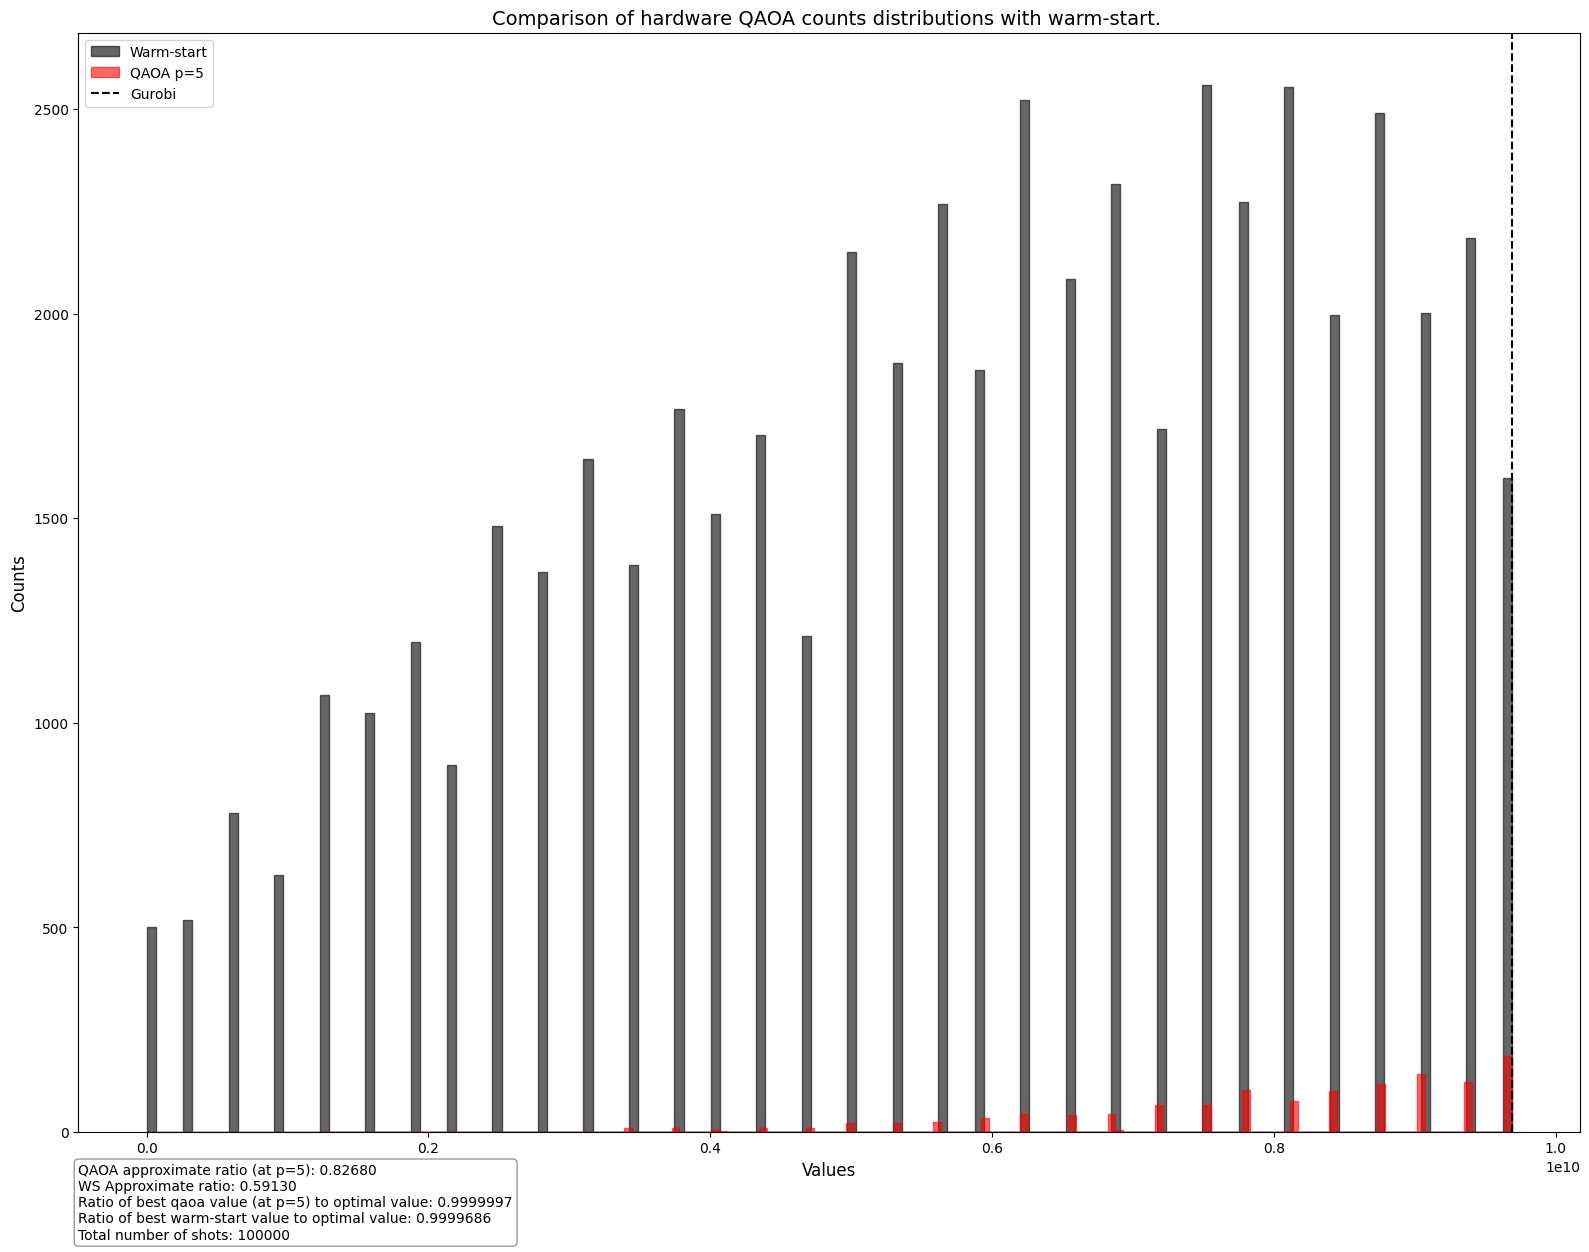

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Comparison of hardware QAOA counts distributions with warm-start. '}, xlabel='Values', ylabel='Counts'>)

In [97]:
data_dict = {
   # f"Random: Apr={norm_approx_ratio_rand:.2f}": dict_bit_values_random,
   f"Warm-start": valid_dict_bit_values_ws,
#    f"QAOA p={1}": hardware_dict_bit_values_at_different_p["p = 0"],
#    f"QAOA p={2}": hardware_dict_bit_values_at_different_p["p = 1"],
#    f"QAOA p={3}": hardware_dict_bit_values_at_different_p["p = 2"],
#    f"QAOA p={4}": hardware_dict_bit_values_at_different_p["p = 3"],
   f"QAOA p={5}": hardware_dict_bit_values_at_different_p["p = 4"]
}   
# Annotations
annotations = {
    f"QAOA approximate ratio (at p={layers})": f"{approx_ratio_qaoa:.5f}",
    f"WS Approximate ratio" : f"{approx_ratio_ws:.5f}",
    f"Ratio of best qaoa value (at p={layers}) to optimal value" : f"{(best_value/optimal_value):.7f}",
    f"Ratio of best warm-start value to optimal value" : f"{(best_value_ws/optimal_value):.7f}",
    f"Total number of shots" : f"{SHOTS:.0f}",
    }
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=150,
    log=False,
    annotations=annotations,
    figsize=(16,12),
    hist_type='stepfilled',
    title=f"Comparison of hardware QAOA counts distributions with warm-start. "
)

### Just for refernce, if we were to repeat the experiment above we 10x more shots, we get the following

In [98]:
job = service.job('d4f7cpkcdebc73evqi10')
hardware_dict_bit_values_at_different_p  = {}

for i in range(len(p_values)):
    counts_bin_qc = job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]

    valid_dict_bit_values_qaoa, invalid_dict_bit_values_qaoa = convert_bitstring_to_values(counts_bin_qc_rev, ordered_values, ordered_weights, capacity)

    #Sort the dictionary by value
    sorted_dict_valid_qaoa= dict(sorted(valid_dict_bit_values_qaoa.items(), key=lambda item: item[0], reverse=True))
    hardware_dict_bit_values_at_different_p[f"p = {i}"] = sorted_dict_valid_qaoa
    best_value = max(sorted_dict_valid_qaoa.keys())
    best_count = sorted_dict_valid_qaoa[best_value]
    print(f"Best value: {best_value}")


    valid_shots_qaoa = sum(sorted_dict_valid_qaoa.values())
    approx_ratio_qaoa, _ = compute_approximate_ratio(dict(islice(sorted_dict_valid_qaoa.items(),valid_shots_qaoa)), optimal_value)

    print(f'Approximate ratio at p = {p_values[i]}: {approx_ratio_qaoa}', '\n' 
        f'Number of valid shots at p = {p_values[i]}: {valid_shots_qaoa}')

Processing bitstrings:   0%|          | 0/998535 [00:00<?, ?it/s]

Best value: 9689004316.0
Approximate ratio at p = 1: 0.6622007868390851 
Number of valid shots at p = 1: 338143


Processing bitstrings:   0%|          | 0/999998 [00:00<?, ?it/s]

Best value: 9689004153.0
Approximate ratio at p = 2: 0.7614857861616277 
Number of valid shots at p = 2: 124709


Processing bitstrings:   0%|          | 0/1000000 [00:00<?, ?it/s]

Best value: 9689104409.0
Approximate ratio at p = 3: 0.7848018341184508 
Number of valid shots at p = 3: 64890


Processing bitstrings:   0%|          | 0/1000000 [00:00<?, ?it/s]

Best value: 9689104286.0
Approximate ratio at p = 4: 0.8147978850667151 
Number of valid shots at p = 4: 25683


Processing bitstrings:   0%|          | 0/1000000 [00:00<?, ?it/s]

Best value: 9689104688.0
Approximate ratio at p = 5: 0.8316217247927638 
Number of valid shots at p = 5: 10284


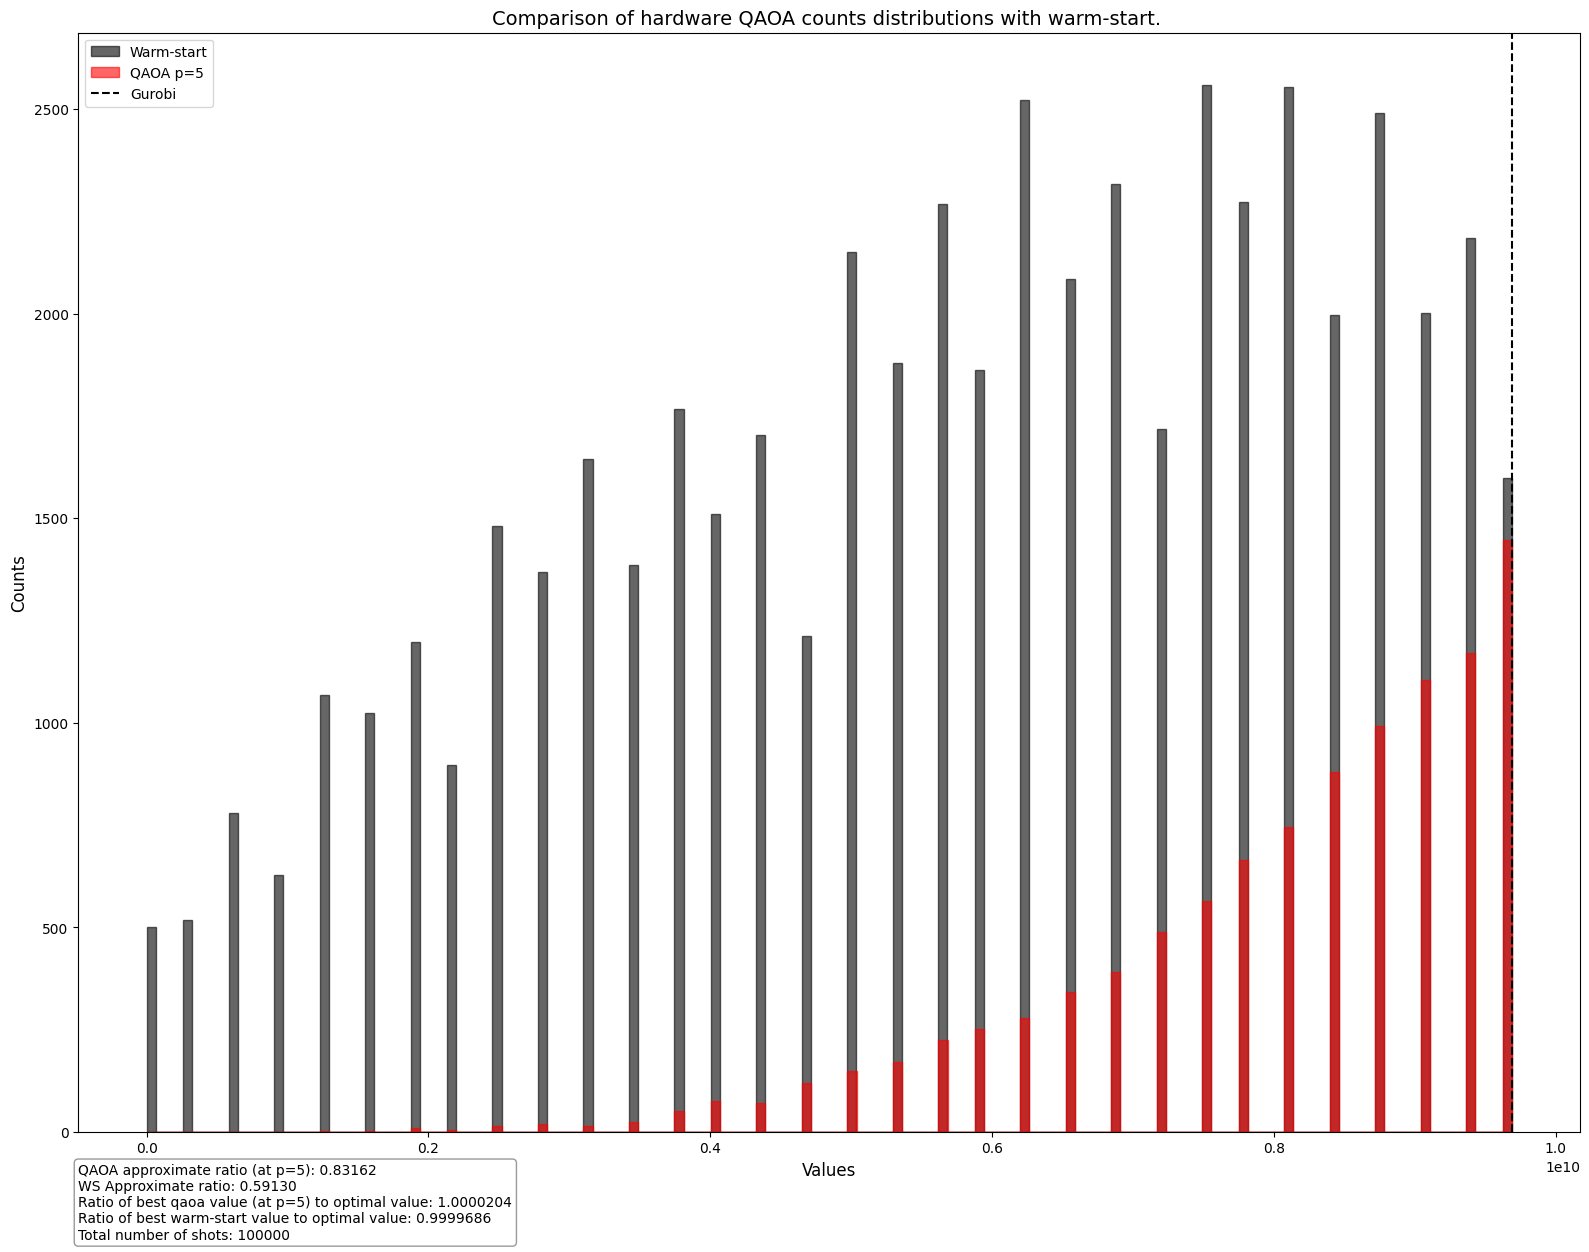

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Comparison of hardware QAOA counts distributions with warm-start. '}, xlabel='Values', ylabel='Counts'>)

In [100]:
data_dict = {
   # f"Random: Apr={norm_approx_ratio_rand:.2f}": dict_bit_values_random,
   f"Warm-start": valid_dict_bit_values_ws,
#    f"QAOA p={1}": hardware_dict_bit_values_at_different_p["p = 0"],
#    f"QAOA p={2}": hardware_dict_bit_values_at_different_p["p = 1"],
#    f"QAOA p={3}": hardware_dict_bit_values_at_different_p["p = 2"],
#    f"QAOA p={4}": hardware_dict_bit_values_at_different_p["p = 3"],
   f"QAOA p={5}": hardware_dict_bit_values_at_different_p["p = 4"]
}   
# Annotations
annotations = {
    f"QAOA approximate ratio (at p={layers})": f"{approx_ratio_qaoa:.5f}",
    f"WS Approximate ratio" : f"{approx_ratio_ws:.5f}",
    f"Ratio of best qaoa value (at p={layers}) to optimal value" : f"{(best_value/optimal_value):.7f}",
    f"Ratio of best warm-start value to optimal value" : f"{(best_value_ws/optimal_value):.7f}",
    f"Total number of shots" : f"{SHOTS:.0f}",
    }
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=150,
    log=False,
    annotations=annotations,
    figsize=(16,12),
    hist_type='stepfilled',
    title=f"Comparison of hardware QAOA counts distributions with warm-start. "
)